## 0. Import Libraries

In [181]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import scipy.constants as sc
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize

import warnings
warnings.filterwarnings('ignore')

## 1. Open GFS Data

### 1.1 GFS

#### 1.1.1 Data Options

In [185]:
general_path = 'data'
dt_type = 'gdas'

# data path
data_path = glob(fr'{general_path}/{"/boundary_input_data"}/*{dt_type}*')

In [186]:
data_path

['data//boundary_input_data/cape_gdas1.fnl0p25.2017071800.f00.grib2.nc',
 'data//boundary_input_data/cape_gdas1.fnl0p25.2017071806.f00.grib2.nc',
 'data//boundary_input_data/cape_gdas1.fnl0p25.2017071812.f00.grib2.nc',
 'data//boundary_input_data/gdas1.fnl0p25.2017071800.f00.grib2.nc',
 'data//boundary_input_data/gdas1.fnl0p25.2017071806.f00.grib2.nc',
 'data//boundary_input_data/gdas1.fnl0p25.2017071812.f00.grib2.nc',
 'data//boundary_input_data/level_gdas1.fnl0p25.2017071800.f00.grib2.nc',
 'data//boundary_input_data/level_gdas1.fnl0p25.2017071806.f00.grib2.nc',
 'data//boundary_input_data/level_gdas1.fnl0p25.2017071812.f00.grib2.nc']

In [187]:
gdas = xr.open_mfdataset(data_path)

In [188]:
gdas

<xarray.Dataset>
Dimensions:          (time: 3, level0: 3, lat: 81, lon: 121)
Coordinates:
  * time             (time) datetime64[ns] 2017-07-18 ... 2017-07-18T12:00:00
  * level0           (level0) float32 1e+03 850.0 500.0
  * lat              (lat) float32 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * lon              (lon) float32 20.0 20.25 20.5 20.75 ... 49.5 49.75 50.0
Data variables:
    valid_date_time  (time) |S10 dask.array<chunksize=(1,), meta=np.ndarray>
    ref_date_time    (time) |S10 dask.array<chunksize=(1,), meta=np.ndarray>
    forecast_hour    (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    TMP_L100         (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    CLWMR_L100       (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    ABS_V_L100       (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    HGT_L100         (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    CAPE_Y108        (time, lat, lon) float32 dask.array<chunksize=(1, 81, 121), meta=np.ndarray>
    R_H_L100         (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
Attributes:
    Creation date and time:  2022-09-12 05:04:11 -0600
    Conventions:             CF-1.5
    Creator:                 NCAR - CISL RDA (dattore)

## 2. Visualization - GFS

### 2.1 Open Land Use Datasets

In [189]:
luse_var = 'LU_INDEX'
urban_luse_border = xr.open_dataset(fr'{general_path}/wrfout_d03_LU_INDEX_urban.nc')[luse_var]
urban_luse_border = urban_luse_border.where(urban_luse_border==1, 0).isel(west_east = slice(35, 162),
                                                                               south_north = slice(57, 157))

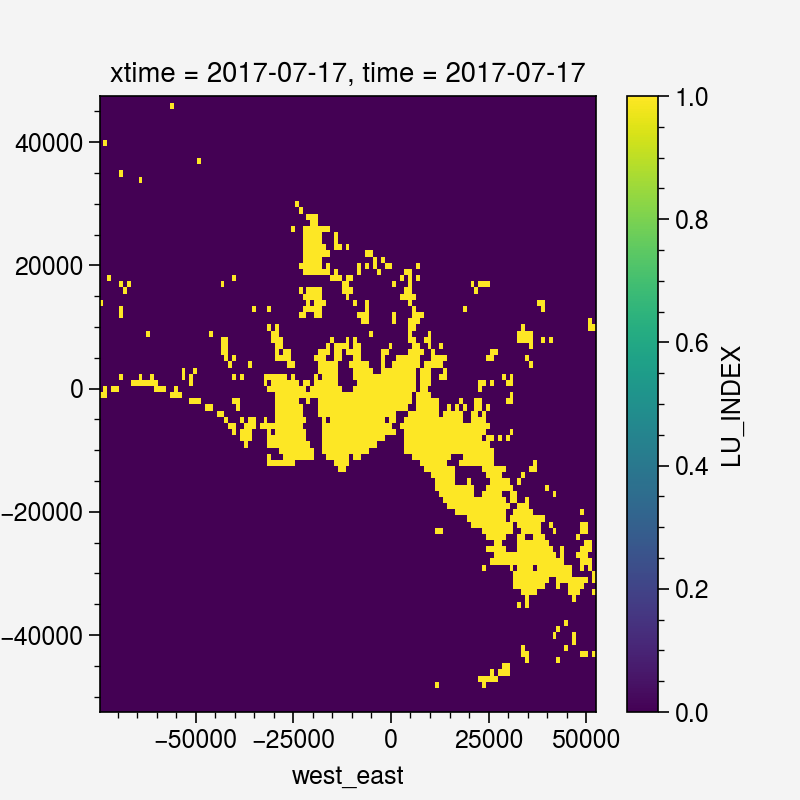

In [190]:
urban_luse_border.plot()

### 2.2 Parameters

In [191]:
cmap_temp = 'seismic'

In [193]:
# Parameters to change (plot) -------------------
# projection
proj = '+proj=lcc +lat_0=41.0720100402832 +lon_0=28.9729995727539 +lat_1=41.0719985961914 +lat_2=41.0719985961914 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'
gdas = gdas.rio.write_crs(proj)
proj = gdas.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1,2],
             [3,4],
             [5,6],
             [7,8],
             [9,10]
            ]
graphic_no = 10
level = 500

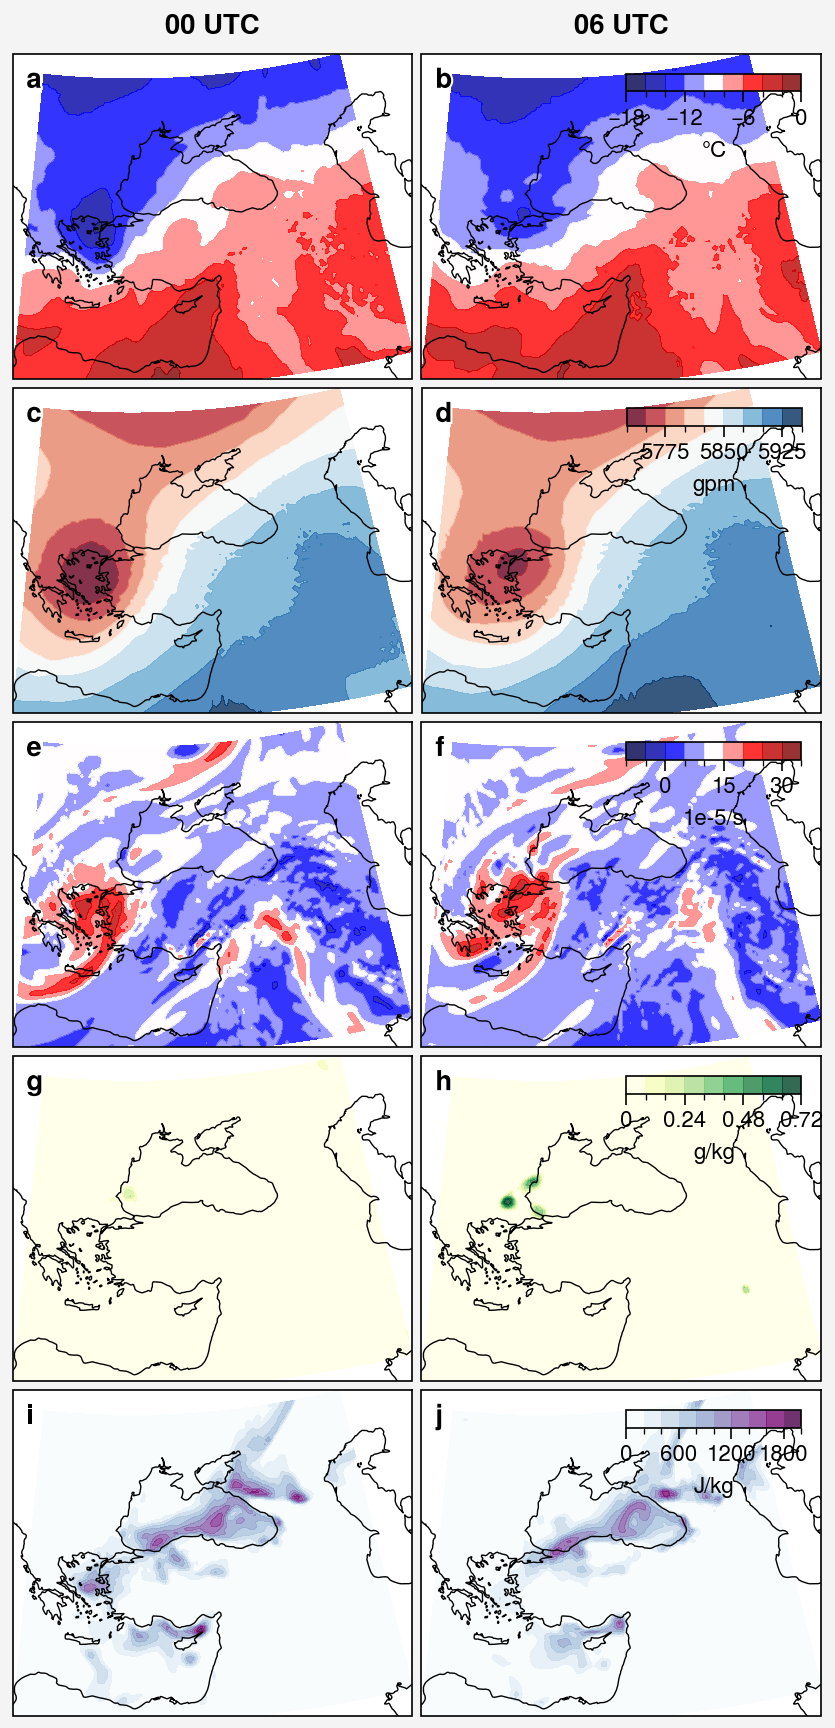

In [194]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=4,
                            axwidth=2,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.36,
                            wspace=0.36,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# istanbul limits
axs.format(lonlim=(20, 50),
           latlim=(30, 50),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(collabels=['00 UTC', '06 UTC'],
           )

#proplot.rc['leftlabel.rotation'] = 'vertical'
proplot.rc.update({'leftlabel.rotation':'vertical'})

# add shapefiles
axs.add_feature(cartopy.feature.LAND.with_scale('50m'),
               zorder=1, linewidths=0.5,
               edgecolor='black', facecolor='none') 
    
    
dt_border = urban_luse_border

# LIN 
# gfs temperature
for i in range(2):
    dt_ = (gdas['TMP_L100'].isel(time=i).sel(level0=level))-273.15
    mesh_temp = axs[i].contourf(gdas['lon'], 
                                gdas['lat'],
                                dt_, 
                                cmap = cmap_temp,
                                vmin = (gdas['TMP_L100'].sel(level0=level)).min().compute().values-2-273.15,
                                vmax = (gdas['TMP_L100'].sel(level0=level)).max().compute().values+2-273.15,
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs geo height
for i in range(2):
    dt_ = (gdas['HGT_L100'].isel(time=i).sel(level0=level))
    mesh_height = axs[i+2].contourf(gdas['lon'], 
                                gdas['lat'],
                                dt_, 
                                cmap = 'RdBu',
                                vmin = (gdas['HGT_L100'].sel(level0=level)).min().compute().values-10,
                                vmax = (gdas['HGT_L100'].sel(level0=level)).max().compute().values+10,
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs abs vort
for i in range(2):
    dt_ = (gdas['ABS_V_L100'].isel(time=i).sel(level0=level))*1e5
    mesh_vort = axs[i+4].contourf(gdas['lon'], 
                                gdas['lat'],
                                dt_, 
                                cmap = cmap_temp,
                                vmin = (gdas['ABS_V_L100'].sel(level0=level)).min().compute().values*1e5,
                                vmax = (gdas['ABS_V_L100'].sel(level0=level)).max().compute().values*1e5,
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs mix rat
for i in range(2):
    dt_ = (gdas['CLWMR_L100'].isel(time=i).sel(level0=level)) * 1000
    mesh_mix = axs[i+6].contourf(gdas['lon'], 
                                gdas['lat'],
                                dt_, 
                                cmap = 'YlGn',
                                vmin = (gdas['CLWMR_L100'].sel(level0=level)).min().compute().values * 1000,
                                vmax = (gdas['CLWMR_L100'].sel(level0=level)).max().compute().values * 1000,
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs cape
for i in range(2):
    dt_ = (gdas['CAPE_Y108'].isel(time=i))
    mesh_cape = axs[i+8].contourf(gdas['lon'], 
                                gdas['lat'],
                                dt_, 
                                cmap = 'BuPu',
                                vmin = (gdas['CAPE_Y108'].min().compute().values),
                                vmax = (gdas['CAPE_Y108'].max().compute().values),
                                zorder = 0.2,
                                alpha=0.8)

# colorbars
axs[1].colorbar(mesh_temp,
                 label='°C',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[3].colorbar(mesh_height,
                 label='gpm',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[5].colorbar(mesh_vort,
                 label='1e-5/s',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[7].colorbar(mesh_mix,
                 label='g/kg',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )
                                        
axs[9].colorbar(mesh_cape,
                 label='J/kg',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

#save figure
plt.savefig(fr'pictures/combined_boundary_data_gdas_{level}.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)

## 3. Open ERA5 Data

### 3.1 ERA5

#### 3.1.1 Data Options

In [195]:
general_path = 'data'
dt_type = 'era5'

# data path
data_path = glob(fr'{general_path}/{"/boundary_input_data"}/*{dt_type}*')

In [196]:
era5 = xr.open_mfdataset(data_path)

In [197]:
era5

<xarray.Dataset>
Dimensions:    (longitude: 121, latitude: 81, time: 4, level: 3)
Coordinates:
  * longitude  (longitude) float32 20.0 20.25 20.5 20.75 ... 49.5 49.75 50.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 2017-07-18 ... 2017-07-18T18:00:00
  * level      (level) int32 500 850 1000
Data variables:
    cape       (time, latitude, longitude) float32 dask.array<chunksize=(4, 81, 121), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(4, 81, 121), meta=np.ndarray>
    z          (time, level, latitude, longitude) float32 dask.array<chunksize=(4, 3, 81, 121), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 dask.array<chunksize=(4, 3, 81, 121), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 dask.array<chunksize=(4, 3, 81, 121), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(4, 3, 81, 121), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 dask.array<chunksize=(4, 3, 81, 121), meta=np.ndarray>
    vo         (time, level, latitude, longitude) float32 dask.array<chunksize=(4, 3, 81, 121), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-09-12 14:02:53 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## 4. Visualization - ERA5

### 4.1 Parameters

In [206]:
cmap_temp = 'seismic'
level = 500

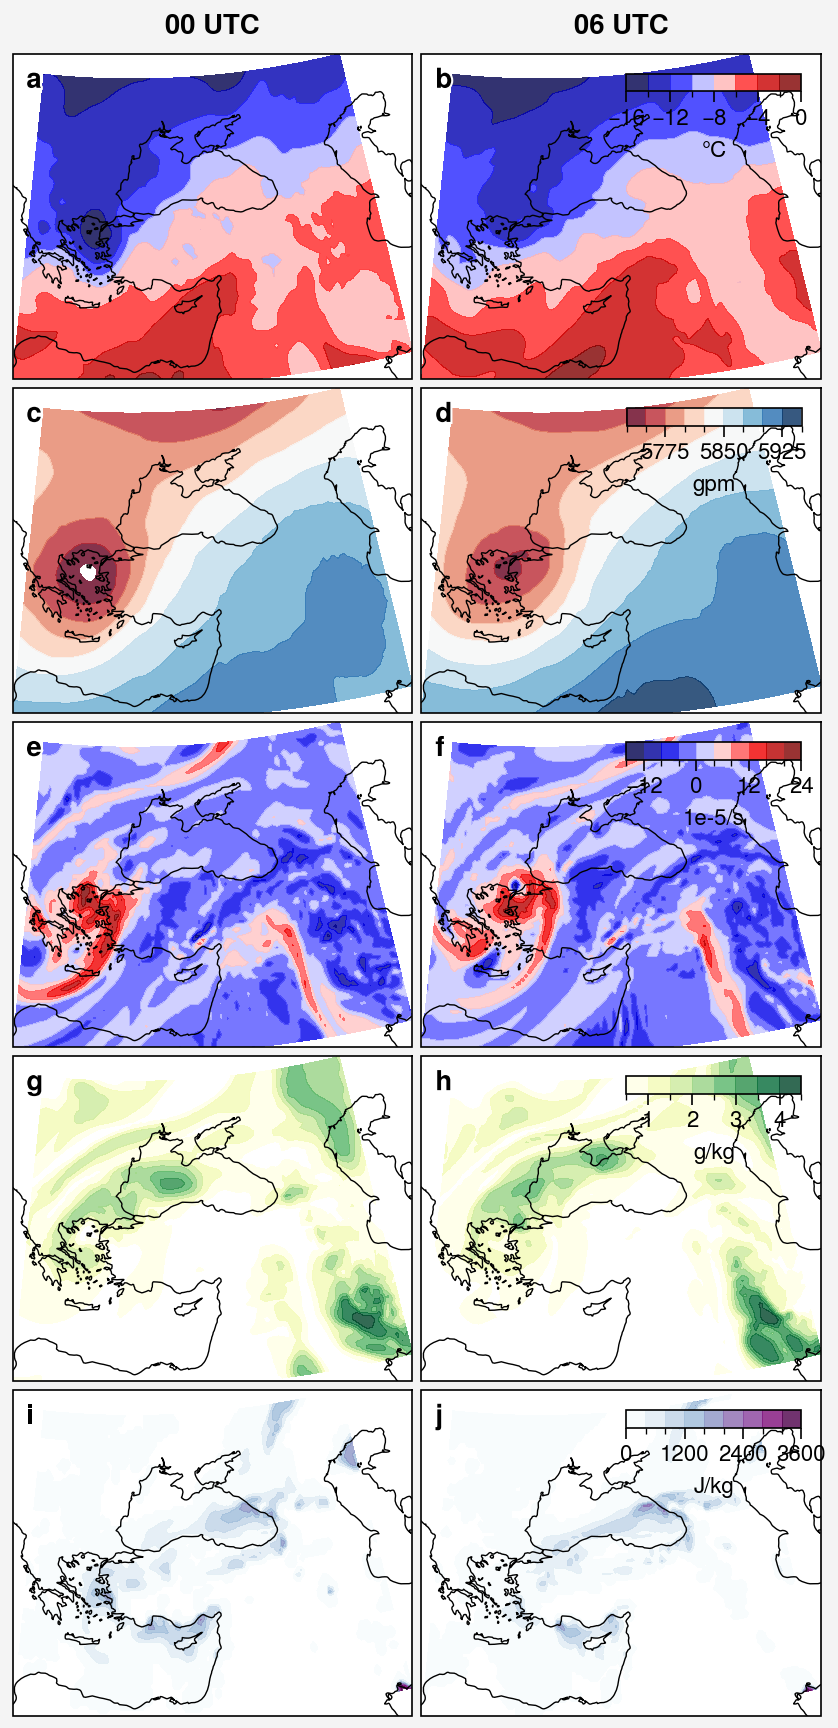

In [207]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=4,
                            axwidth=2,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.36,
                            wspace=0.36,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# istanbul limits
axs.format(lonlim=(20, 50),
           latlim=(30, 50),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(collabels=['00 UTC', '06 UTC'],
           )

#proplot.rc['leftlabel.rotation'] = 'vertical'
proplot.rc.update({'leftlabel.rotation':'vertical'})

# add shapefiles
axs.add_feature(cartopy.feature.LAND.with_scale('50m'),
               zorder=1, linewidths=0.5,
               edgecolor='black', facecolor='none') 
    
    
dt_border = urban_luse_border

# LIN 
# gfs temperature
for i in range(2):
    dt_ = (era5['t'].isel(time=i).sel(level=level))-273.15
    mesh_temp = axs[i].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_, 
                                cmap = cmap_temp,
                                vmin = (era5['t'].sel(level=level)).min().compute().values-2-273.15,
                                vmax = (era5['t'].sel(level=level)).max().compute().values+2-273.15,
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs geo height
for i in range(2):
    dt_ = (era5['z'].isel(time=i).sel(level=level)) / sc.g
    mesh_height = axs[i+2].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_, 
                                cmap = 'RdBu',
                                vmin = (era5['z'].sel(level=level)).min().compute().values / sc.g -20,
                                vmax = (era5['z'].sel(level=level)).max().compute().values / sc.g +20,
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs rel vort
for i in range(2):
    dt_ = (era5['vo'].isel(time=i).sel(level=level))*1e5
    mesh_vort = axs[i+4].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_, 
                                cmap = cmap_temp,
                                vmin = (era5['vo'].sel(level=level)).min().compute().values*1e5,
                                vmax = (era5['vo'].sel(level=level)).max().compute().values*1e5,
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs spe hum
for i in range(2):
    dt_ = (era5['q'].isel(time=i).sel(level=level)) * 1000
    mesh_mix = axs[i+6].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_, 
                                cmap = 'YlGn',
                                vmin = (era5['q'].sel(level=level)).min().compute().values * 1000,
                                vmax = (era5['q'].sel(level=level)).max().compute().values * 1000,
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs cape
for i in range(2):
    dt_ = (era5['cape'].isel(time=i))
    mesh_cape = axs[i+8].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_, 
                                cmap = 'BuPu',
                                vmin = (era5['cape'].min().compute().values),
                                vmax = (era5['cape'].max().compute().values),
                                zorder = 0.2,
                                alpha=0.8)

# colorbars
axs[1].colorbar(mesh_temp,
                 label='°C',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[3].colorbar(mesh_height,
                 label='gpm',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[5].colorbar(mesh_vort,
                 label='1e-5/s',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[7].colorbar(mesh_mix,
                 label='g/kg',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )
                                        
axs[9].colorbar(mesh_cape,
                 label='J/kg',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

#save figure
plt.savefig(fr'pictures/combined_boundary_data_era5_{level}.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)